In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
import os
print(os.getcwd())


/Users/marcovalsania/Downloads


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/marcovalsania/Downloads/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

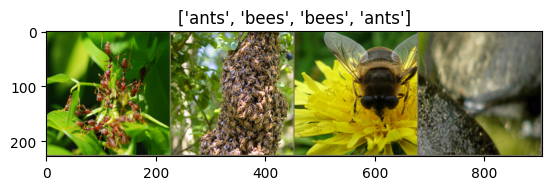

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [57]:
#original
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     # Create a temporary directory to save training checkpoints
#     with TemporaryDirectory() as tempdir:
#         best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

#         torch.save(model.state_dict(), best_model_params_path)
#         best_acc = 0.0

#         for epoch in range(num_epochs):
#             print(f'Epoch {epoch}/{num_epochs - 1}')
#             print('-' * 10)

#             # Each epoch has a training and validation phase
#             for phase in ['train', 'val']:
#                 if phase == 'train':
#                     model.train()  # Set model to training mode
#                 else:
#                     model.eval()   # Set model to evaluate mode

#                 running_loss = 0.0
#                 running_corrects = 0

#                 # Iterate over data.
#                 for inputs, labels in dataloaders[phase]:
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.set_grad_enabled(phase == 'train'):
#                         outputs = model(inputs)
#                         _, preds = torch.max(outputs, 1)
#                         loss = criterion(outputs, labels)

#                         # backward + optimize only if in training phase
#                         if phase == 'train':
#                             loss.backward()
#                             optimizer.step()

#                     # statistics
#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)
#                 if phase == 'train':
#                     scheduler.step()

#                 epoch_loss = running_loss / dataset_sizes[phase]
#                 epoch_acc = running_corrects.double() / dataset_sizes[phase]

#                 print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#                 # deep copy the model
#                 if phase == 'val' and epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     torch.save(model.state_dict(), best_model_params_path)

#             print()

#         time_elapsed = time.time() - since
#         print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#         print(f'Best val Acc: {best_acc:4f}')

#         # load best model weights
#         model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
#     return model

In [10]:
#adapted
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # Move inputs and labels to MPS device and convert to float32
                    inputs = inputs.to(device, dtype=torch.float32)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimize only in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]  # Use float32 instead of double

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save the best model parameters
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path, map_location=device))

    return model



In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6808 Acc: 0.6680
val Loss: 0.3130 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5695 Acc: 0.7418
val Loss: 0.3192 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4302 Acc: 0.8279
val Loss: 0.2347 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5441 Acc: 0.7746
val Loss: 0.6634 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.4534 Acc: 0.8074
val Loss: 0.5121 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.5355 Acc: 0.8033
val Loss: 0.2839 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3919 Acc: 0.8443
val Loss: 0.2543 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3100 Acc: 0.8811
val Loss: 0.2492 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3400 Acc: 0.8402
val Loss: 0.2133 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3613 Acc: 0.8648
val Loss: 0.2243 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2757 Acc: 0.8730
val Loss: 0.2242 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3165 Acc: 0.8566
val Loss: 0.2271 Acc: 0.9281

Ep

/var/folders/gg/cck9bvjj3wxb27dbfn4d7nd40000gn/T/ipykernel_5107/3538757512.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

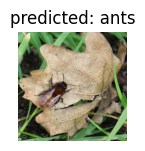

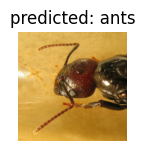

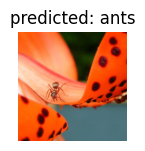

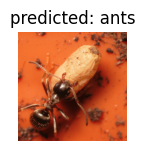

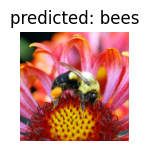

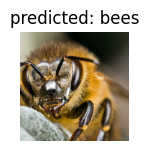

In [14]:
visualize_model(model_ft)

In [15]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5709 Acc: 0.6967
val Loss: 0.2686 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5475 Acc: 0.7541
val Loss: 0.2640 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4641 Acc: 0.7951
val Loss: 0.3877 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.5477 Acc: 0.7869
val Loss: 0.3683 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.6691 Acc: 0.7869
val Loss: 0.1742 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4930 Acc: 0.8033
val Loss: 0.3036 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5346 Acc: 0.7828
val Loss: 0.2539 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3162 Acc: 0.8689
val Loss: 0.1973 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3455 Acc: 0.8443
val Loss: 0.1983 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3052 Acc: 0.8689
val Loss: 0.1851 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.8443
val Loss: 0.1778 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3020 Acc: 0.8770
val Loss: 0.2030 Acc: 0.9346

Ep

/var/folders/gg/cck9bvjj3wxb27dbfn4d7nd40000gn/T/ipykernel_5107/3538757512.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

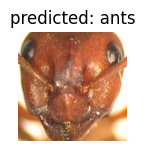

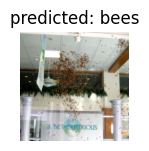

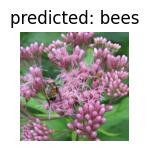

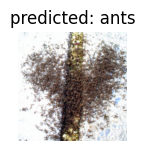

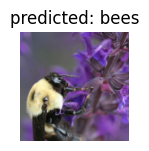

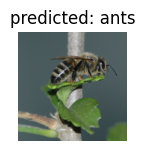

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [18]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

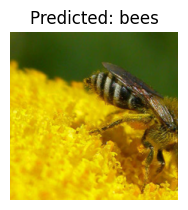

In [24]:
visualize_model_predictions(
    model_conv,
    img_path='/Users/marcovalsania/Downloads/hymenoptera_data/val/bees/26589803_5ba7000313.jpg'
)

plt.ioff()
plt.show()